In [1]:
cd ..

/Users/joeranbosma/stack/Projects/M5Forecast


In [27]:
# basic imports
import os
import numpy as np
import pandas as pd
from tqdm import tqdm as tqdm
import matplotlib.pyplot as plt

# tensorflow imports
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Reshape, concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# own imports
from flow import load_data, select_dates, sales_to_money, select_final_day, create_submission, select_day_nums
from evaluation import Referee, RapidReferee, CrossValiDataGenerator
from agent import KDayMeanTimesWeeklyPattern, AggregateAgent
from train import BatchCreator, Logger, make_loss

In [3]:
os.environ['DATA_DIR'] = 'data/'
os.environ['SUB_DIR'] = 'submissions/'
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # for MacOS TF bug

# General settings for figures
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["savefig.transparent"] = True
plt.rcParams.update({'font.size': 13})  # 12, 16
plt.rcParams["savefig.bbox"] = 'tight'

# Top Down for M5Forecast - Accuracy - Multi input

The proof of concept to use a 1D CNN to predict aggregated store sales was done in `top-down-stores-proof-of-concept.ipynb`. To this the level 3 WRMSSE as training loss was added in `top-down-stores-wrmsse-loss.ipynb`. Here, more advanced pipelines are investigated, specifically with multiple inputs for the network. 

The aggregated sales of the stores are predicted directly by the model, instead of calculating the sales by aggregating product-level predictions.  


To convey which information should flow where, the `features` can either be a list of column names (single input), or a dictionary of columns names. For example:

```
features = {
    'inp_cnn': ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'],
    'inp_mlp': ['wday_%d'%d for d in range(1, 1+7)]
}
```

Feeds the aggregated sales to the convolutional network (for which the Input should be named `inp_cnn`) and the one-hot encoded day of the week is send to the Dense part of the network. 

In [6]:
# Load data
calendar, sales_train_validation, sell_prices = load_data()

# Set up generator
cv_generator = CrossValiDataGenerator(sales_train_validation)
sales_train, sales_true = cv_generator.get_train_val_split(fold=10, train_size=-1)

# create referee for fold 10
ref = Referee(sales_true, sales_train, sell_prices, calendar)

Calculating weights for each level...
Calculating scale for each level...
Finished setup.


## Extend pipeline with information about day of the week

In [7]:
def preprocess_wday(sales, prices=None, calendar=None, norm=None):
    """Convert sales to a suitable format for the BatchCreator"""
    
    # Calculate aggregated sales
    df = sales.groupby(['store_id']).sum()
    
    # Transpose sales such that d_num_start, ... is the index
    df = df.T
    
    # Normalize sales
    if norm is None:
        norm = df.max().max()
    df /= norm
    
    # Include weekday
    wday = df.apply(lambda row: calendar[calendar.d == row.name].wday.values[0], axis=1)
    wday_onehot = pd.get_dummies(wday, prefix='wday')
    
    # merge with dataset
    df = pd.merge(wday_onehot, df, left_index=True, right_index=True)
    
    features = list(df.columns)
    return df, norm

In [87]:
# Get suitable train df
train_df, train_norm = preprocess_wday(sales_train, sell_prices, calendar)

In [88]:
labels = ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
features = {
    'inp_cnn': labels,
    'inp_mlp': ['wday_%d'%d for d in range(1, 1+7)]
}

# Set up batch creator
window_in, window_out = 28, 28
batch_creator = BatchCreator(df=train_df, features=features, labels=labels, 
                             window_in=window_in, window_out=window_out)

# Test if batch creator works
# x, y = next(batch_creator.flow())
# print("Input[0]: {}, output[0]: {}".format(x[0], y[0]))
# batch_creator.on_epoch_end()  # reset generator

In [99]:
from tensorflow.keras.layers import Flatten, concatenate

def get_model(inp_shape_cnn, inp_shape_mlp, out_shape, loss="MSE"):
    # clear previous sessions
    K.clear_session()

    # add first layer with correct input size
    inp_cnn = Input(shape=inp_shape_cnn, name="inp_cnn")
    x = Reshape((np.prod(inp_shape_cnn), 1))(inp_cnn)
    
    x = Conv1D( 8, kernel_size=3, padding="same", activation="relu")(x)
    x = Conv1D(16, kernel_size=3, padding="same", activation="relu")(x)
    x = Conv1D(32, kernel_size=3, padding="same", activation="relu")(x)
    x = Conv1D( 1, kernel_size=1, activation="relu")(x)
    x = Flatten()(x)
    
    inp_mlp = Input(shape=inp_shape_mlp, name="inp_mlp")
    y = Flatten()(inp_mlp)
    y = concatenate([x, y])
    y = Dense(512, activation="relu")(y)
    out = Dense(np.prod(out_shape), activation="linear", name="output")(y)
    out = Reshape(out_shape)(out)
    
    model = Model(inputs=[inp_cnn, inp_mlp], outputs=out)

    model.compile(loss=loss, optimizer="adam", metrics=[loss])
    
    return model

model = get_model(inp_shape_cnn=(window_in, len(features["inp_cnn"])), 
                  inp_shape_mlp=(window_in, len(features["inp_mlp"])),
                  out_shape=(window_out, batch_creator.n_labels), 
                   loss=make_loss(ref, train_norm=train_norm))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp_cnn (InputLayer)            [(None, 28, 10)]     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 280, 1)       0           inp_cnn[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 280, 8)       32          reshape[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 280, 16)      400         conv1d[0][0]                     
______________________________________________________________________________________________

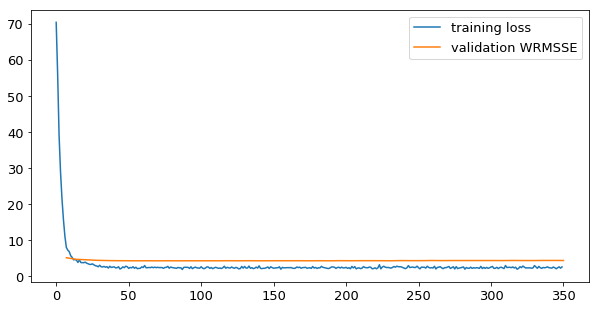

7/7 [==============================] - 2s 289ms/step - loss: 2.3057 - WRMSSE_store: 2.3057


In [100]:
logger = Logger(ref=ref, cv_generator=cv_generator, prices=sell_prices, calendar=calendar,
                train_norm=train_norm, features=features, preprocess_func=preprocess_wday, 
                agent=AggregateAgent(model=model, train_norm=train_norm, features=features, 
                                     labels=features['inp_cnn'], window_in=window_in),
                folds = np.arange(1, 1+10), plot_loss_max=1.5)

history = model.fit(batch_creator.flow(), epochs=50,
                    steps_per_epoch=batch_creator.n // batch_creator.batch_size,
                    callbacks=[logger])

## Evaluate performance

Mean WRMSSE level 3: 4.27629783220774


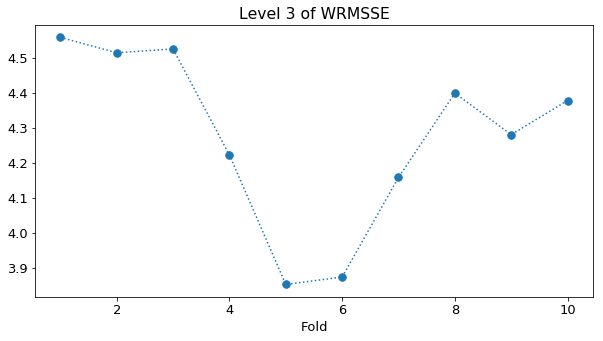

In [101]:
# evaluate model on final 10 folds
WRMSSE_mean, WRMSSE_list = logger.validate()
print("Mean WRMSSE level 3: {}".format(WRMSSE_mean))

f, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(WRMSSE_list))+1, WRMSSE_list, '.:', ms=15)
ax.set_xlabel("Fold")
ax.set_title("Level 3 of WRMSSE")
plt.show()